In [ ]:
### Some parts of the code depend on Siqi Wu's code: https://github.com/avalanchesiqi/networked-popularity
### In order to run the code, please clone Siqi Wu's repo and put this file in the root directory.
### Remember to download all data from https://drive.google.com/drive/folders/19R3_2hRMVqlMGELZm47ruk8D9kqJvAmL?usp=sharing
### And put all data to the data folder.

### Author: Yutian Zhao
### Reference from: Siqi Wu

<h1> Artist Bridges </h1>

In [76]:
from IPython.display import HTML
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

In [1]:
import sys, os, platform, pickle, json, time
from datetime import datetime, timedelta
import numpy as np
from collections import Counter, defaultdict
import networkx as nx
from tqdm import tqdm
import math
import scipy as sp
import scipy.stats
from collections import defaultdict 

from utils.data_loader import DataLoader
from utils.plot import ColorPalette, concise_fmt, hide_spines, stackedBarPlot
data_prefix = 'data/' # ../

# from powerlaw import Fit, plot_ccdf

import matplotlib as mpl
if platform.system() == 'Linux':
    mpl.use('Agg')  # no UI backend

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
mpl.rcParams['lines.linewidth'] = 1

T = 63

In [2]:
data_loader = DataLoader()
data_loader.load_embed_content_dict()
# data_loader.cwd
embed_view_dict = data_loader.embed_view_dict
embed_avg_view_dict = data_loader.embed_avg_view_dict
num_videos = data_loader.num_videos
embed_title_dict = data_loader.embed_title_dict
embed_cid_dict = data_loader.embed_cid_dict

>>> Daily view data has been loaded!


In [3]:
### contrust network graph for each day
if not os.path.exists(os.path.join(data_prefix, "artist_network.pkl")):
    graph_lst = []
    for i in edges:
        G = nx.DiGraph()
        G.add_edges_from(i)
        graph_lst.append(G)
        
    with open(os.path.join(data_prefix, "artist_network.pkl"), 'wb') as fout:
        pickle.dump(graph_lst, fout)
else:
    with open(os.path.join(data_prefix, "artist_network.pkl"), 'rb') as fin:
        graph_lst = pickle.load(fin)

In [4]:
scc_list = [nx.strongly_connected_components(G) for G in graph_lst]
lscc_list = [max(scc, key=len) for scc in scc_list]
lwcc_list = [max(nx.weakly_connected_components(G), key=len) for G in graph_lst]

In [5]:
lscc_subgraph_list = [graph_lst[i].subgraph(lscc_list[i]) for i in range(T)]

In [6]:
# if not os.path.exists(os.path.join(data_prefix, "lwcc_subgraph_list_15.pkl")):
    
#     with open(os.path.join(data_prefix, "lwcc_subgraph_list_15.pkl"), 'wb') as fout:
#         pickle.dump(lwcc_subgraph_list, fout)
# else:
#     with open(os.path.join(data_prefix, "lwcc_subgraph_list_15.pkl"), 'rb') as fin:
#         lwcc_subgraph_list = pickle.load(fin)
lwcc_subgraph_list = [(graph_lst[i].subgraph(lwcc_list[i])) for i in range(T)]

In [77]:
counter = Counter()
for lscc in lscc_list:
    counter.update(lscc)

avg_views = []
days_in_lscc = []
ids_lscc = []
for i in counter.keys():
    ids_lscc.append(i)
    avg_views.append(c_emb_avg_view_dict[i])
    days_in_lscc.append(counter[i])

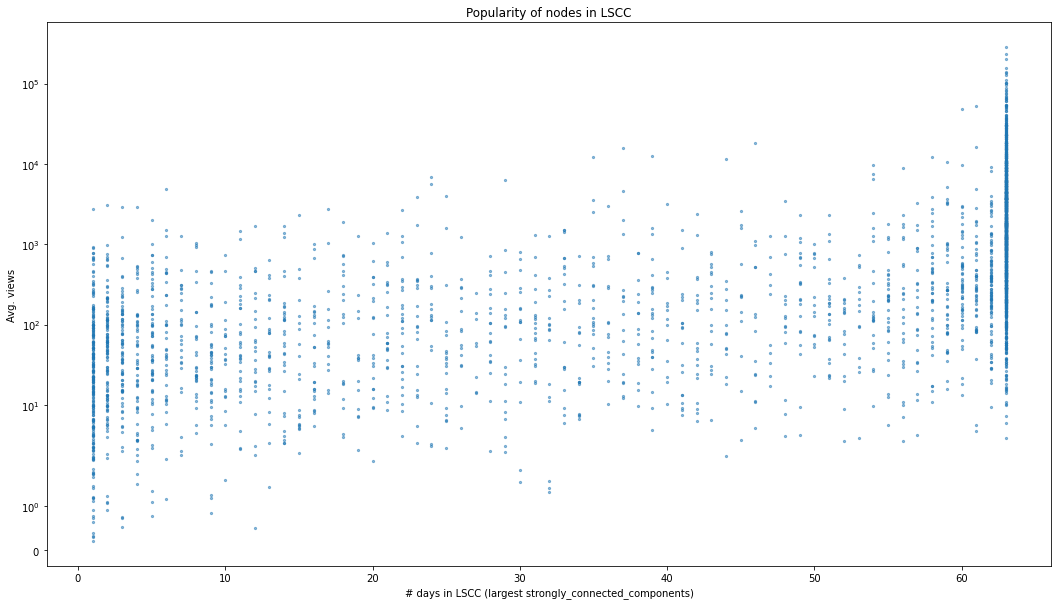

In [78]:
plt.figure(figsize=(18,10))
plt.scatter(days_in_lscc, avg_views, s=5, marker='o', alpha=0.5)
plt.title("Popularity of nodes in LSCC")
plt.xlabel("# days in LSCC (largest strongly_connected_components)")
plt.ylabel("Avg. views")
# plt.xscale('log')
plt.yscale('symlog')
plt.show();

Similar to the one for videos, most of the nodes are either persistent or temporary.

In [79]:
days_avg_views = sorted(zip(days_in_lscc, avg_views), key=lambda x: x[1])
def strict_percentile(lst):
    p_lst = []
    for i in range(len(lst)):
        j = i
        while j >= 1:
            if lst[j-1] != lst[i]:
                break
            else:
                j = j-1
        p_lst.append((j+1)/len(lst))
    return p_lst            
p_lst = strict_percentile(sorted(avg_views))
sorted_days_in_lscc =list(zip(*days_avg_views))[0]

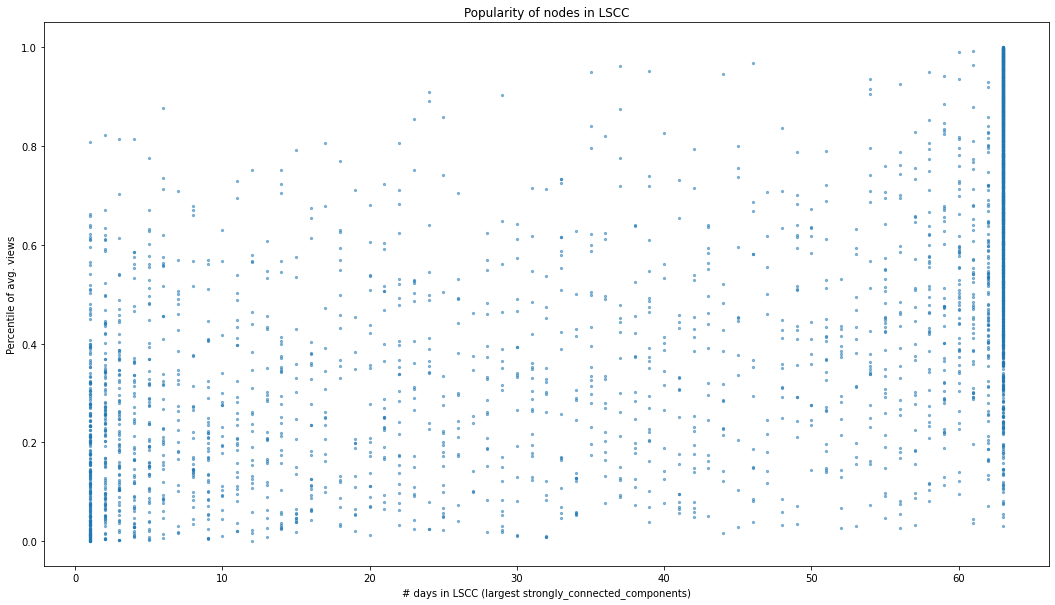

In [80]:
plt.figure(figsize=(18,10))
plt.scatter(sorted_days_in_lscc, p_lst, s=5, marker='o', alpha=0.5)
plt.title("Popularity of nodes in LSCC")
plt.xlabel("# days in LSCC (largest strongly_connected_components)")
plt.ylabel("Percentile of avg. views")
# plt.xscale('log')
# plt.yscale('symlog')
plt.show();

In [7]:
def dfs_edges(v, graph):
    # parent = {}
    start = defaultdict(int)
#     visited = defaultdict(bool)
    end = defaultdict(int)
    # entering u
    forward_edges = defaultdict(list)
    back_edges = defaultdict(list)
    cross_edges = defaultdict(list)
    tree_edges = []
    t = 0
#     print("entering dfs edges")

#     def dfs(v, graph, parent=None):
#         nonlocal t
#         t += 1
#         start[v] = t
#         if parent is not None:
#             tree_edges.append((parent, v))
#         for n in graph.successors(v):
#             if start[n] == 0:  # not visited
#                 dfs(n, graph, parent=v)
#             elif end[n] == 0:
#                 back_edges[n].append(v)
#             elif start[v] < start[n]:
#                 forward_edges[n].append(v)
#             else:
#                 cross_edges[n].append(v)
#         t += 1
#         end[v] = t
        
    def dfs(v, graph):
        nonlocal t
        stack = []
        stack.append((v, None)) # (v, parent)

        while (len(stack)):
            t += 1
            v, parent = stack[-1]
            if start[v] > 0 and end[v] == 0:
                end[v] = t
                stack.pop()
            elif start[v] > 0 and end[v] > 0:
                forward_edges[v].append(parent)
                stack.pop()
            else:
                start[v] = t
                if parent is not None:
                    tree_edges.append((parent, v))
#                 for n in sorted(graph.successors(v), reverse=True):
                for n in graph.successors(v):
                    if start[n] == 0:  # not visited
                        stack.append((n, v))
                    elif end[n] == 0:
                        back_edges[n].append(v)
                    elif start[v] < start[n]:
                        forward_edges[n].append(v)
                    else:
                        cross_edges[n].append(v)
            
    dfs(v, graph)
    
    return tree_edges, back_edges, forward_edges, cross_edges

def dominator_tree(v, graph):
    dt = nx.DiGraph()
#     print("entering dominator_tree")
    idoms = nx.immediate_dominators(graph, v)
    for k, v in idoms.items():
        if k != v:
            dt.add_edge(v, k)
    return dt

def dfs_order(v, graph, ):
    start = defaultdict(int)
    end = defaultdict(int)
    t = 0
#     print("entering dfs order")
    
#     def dfs(v, graph,):
#         nonlocal t
#         t += 1
#         start[v] = t
#         for n in graph.successors(v):
#             if start[n] == 0:  # not visited
#                 dfs(n, graph, )
#         t += 1
#         end[v] = t
        
    def dfs(v, graph):
        nonlocal t
        stack = []
        stack.append((v, None)) # (v, parent)

        while (len(stack)):
            t += 1
            v, parent = stack[-1]
            if start[v] > 0 and end[v] == 0:
                end[v] = t
                stack.pop()
            elif start[v] > 0 and end[v] > 0:
                stack.pop()
            else:
                start[v] = t
#                 for n in sorted(graph.successors(v), reverse=True):
                for n in graph.successors(v):
                    if start[n] == 0:  # not visited
                        stack.append((n, v))
        
    dfs(v, graph)
    
    return start, end

def edge_dominators(v, graph):    
    edge_dominator = set()
    tree_edges, back_edges, forward_edges, cross_edges = dfs_edges(v, graph)
#     print("finish dfs edges")
    dt = dominator_tree(v, graph)
#     print("finish dominator_tree")
    start, end = dfs_order(v, dt)
#     print("finish dfs_order")
    for e in tree_edges:
        if len(forward_edges[e[1]])==0 and len(cross_edges[e[1]])==0:
            flag = True
            for i in back_edges[e[1]]:  # for every back edge, e_1 dominate i
                if not ((start[e[1]] < start[i]) and (end[i] < end[e[1]])):
                    flag = False
            if flag:
                edge_dominator.add(e)
    return edge_dominator

def strong_edges(v, graph):
#     print("here")
    de = edge_dominators(v, graph)
    for v, u in edge_dominators(v, graph.reverse()):
        de.add((u, v))
    return de

In [8]:
### LSCC
## list of strong edges
def choose_node(scc):
    v = scc.pop()
    scc.add(v)
    return v

node_list = [choose_node(scc) for scc in lscc_list]

In [9]:
if not os.path.exists(os.path.join(data_prefix, "se_list_artist_15.pkl")):
    se_list = [] 
    for i in range(T):
        se = strong_edges(node_list[i], lscc_subgraph_list[i])
        print("finish se ", i)
        se_list.append(se)
    print("done") 
    
    with open(os.path.join(data_prefix, "se_list_artist_15.pkl"), 'wb') as fout:
        pickle.dump(se_list, fout)
else:
    with open(os.path.join(data_prefix, "se_list_artist_15.pkl"), 'rb') as fin:
        se_list = pickle.load(fin)

se_len_list = [len(i) for i in se_list]

finish se  0
finish se  1
finish se  2
finish se  3
finish se  4
finish se  5
finish se  6
finish se  7
finish se  8
finish se  9
finish se  10
finish se  11
finish se  12
finish se  13
finish se  14
finish se  15
finish se  16
finish se  17
finish se  18
finish se  19
finish se  20
finish se  21
finish se  22
finish se  23
finish se  24
finish se  25
finish se  26
finish se  27
finish se  28
finish se  29
finish se  30
finish se  31
finish se  32
finish se  33
finish se  34
finish se  35
finish se  36
finish se  37
finish se  38
finish se  39
finish se  40
finish se  41
finish se  42
finish se  43
finish se  44
finish se  45
finish se  46
finish se  47
finish se  48
finish se  49
finish se  50
finish se  51
finish se  52
finish se  53
finish se  54
finish se  55
finish se  56
finish se  57
finish se  58
finish se  59
finish se  60
finish se  61
finish se  62
done


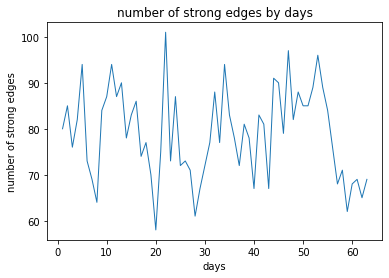

In [10]:
## length of se_list
plt.plot([*range(1,64)], se_len_list)
plt.title("number of strong edges by days")
plt.xlabel("days")
plt.ylabel("number of strong edges")
plt.show();

In [11]:
## appear times
def appear_times(se_list):
    se_times = defaultdict(int)
    for i in range(T):
        for j in se_list[i]:
            se_times[j] += 1
    se_times_sorted = sorted(se_times.items(), key=lambda x: x[1], reverse=True)
    return se_times, se_times_sorted

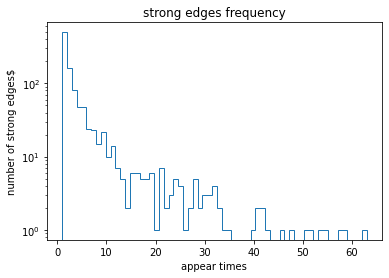

In [12]:
se_times, se_times_sorted = appear_times(se_list)
plt.hist(se_times.values(), bins=63, density=False, log=True, histtype="step")
plt.title("strong edges frequency")
plt.ylabel('number of strong edges$')
plt.xlabel('appear times')
plt.show();

In [13]:
if not os.path.exists(os.path.join(data_prefix, "artist_list_15.pkl")):
    bridge_list = []
    for i in tqdm(range(T)):
        b_lst = []
        bridges = nx.bridges(lwcc_subgraph_list[i].to_undirected())
        
        print("finish be ", i)
        for b in tqdm(bridges):
            b_lst.append(b)
        bridge_list.append(b_lst)
        print("finish b ", len(b_lst))
        
    with open(os.path.join(data_prefix, "artist_list_15.pkl"), 'wb') as fout:
        pickle.dump(bridge_list, fout)
else:
    with open(os.path.join(data_prefix, "artist_list_15.pkl"), 'rb') as fin:
        bridge_list = pickle.load(fin)
        
bridge_len_list = [len(b) for b in bridge_list]

  0%|                                                                                           | 0/63 [00:00<?, ?it/s]
0it [00:00, ?it/s]

finish be  0



163it [00:00, 358.47it/s]
  2%|█▎                                                                                 | 1/63 [00:00<00:48,  1.27it/s]

finish b  163



0it [00:00, ?it/s]

finish be  1



150it [00:00, 272.45it/s]
  3%|██▋                                                                                | 2/63 [00:01<00:52,  1.15it/s]

finish b  150



0it [00:00, ?it/s]

finish be  2



142it [00:00, 287.84it/s]
  5%|███▉                                                                               | 3/63 [00:02<00:51,  1.16it/s]

finish b  142



0it [00:00, ?it/s]

finish be  3



150it [00:00, 334.94it/s]
  6%|█████▎                                                                             | 4/63 [00:03<00:48,  1.21it/s]

finish b  150



0it [00:00, ?it/s]

finish be  4



167it [00:00, 379.70it/s]
  8%|██████▌                                                                            | 5/63 [00:04<00:46,  1.24it/s]

finish b  167



0it [00:00, ?it/s]

finish be  5



158it [00:00, 287.52it/s]
 10%|███████▉                                                                           | 6/63 [00:05<00:47,  1.19it/s]

finish b  158



0it [00:00, ?it/s]

finish be  6



157it [00:00, 339.99it/s]
 11%|█████████▏                                                                         | 7/63 [00:05<00:46,  1.20it/s]

finish b  157



0it [00:00, ?it/s]

finish be  7



152it [00:00, 330.17it/s]
 13%|██████████▌                                                                        | 8/63 [00:06<00:44,  1.23it/s]

finish b  152



0it [00:00, ?it/s]

finish be  8



168it [00:00, 380.23it/s]
 14%|███████████▊                                                                       | 9/63 [00:07<00:43,  1.24it/s]

finish b  168



0it [00:00, ?it/s]

finish be  9



173it [00:00, 382.07it/s]
 16%|█████████████                                                                     | 10/63 [00:08<00:52,  1.00it/s]

finish b  173



0it [00:00, ?it/s]

finish be  10



178it [00:00, 413.14it/s]
 17%|██████████████▎                                                                   | 11/63 [00:09<00:47,  1.08it/s]

finish b  178



0it [00:00, ?it/s]

finish be  11



177it [00:00, 376.00it/s]
 19%|███████████████▌                                                                  | 12/63 [00:10<00:45,  1.13it/s]

finish b  177



0it [00:00, ?it/s]

finish be  12



150it [00:00, 275.97it/s]
 21%|████████████████▉                                                                 | 13/63 [00:11<00:45,  1.10it/s]

finish b  150



0it [00:00, ?it/s]

finish be  13



148it [00:00, 229.36it/s]
 22%|██████████████████▏                                                               | 14/63 [00:12<00:48,  1.02it/s]

finish b  148



0it [00:00, ?it/s]

finish be  14



137it [00:00, 212.64it/s]
 24%|███████████████████▌                                                              | 15/63 [00:13<00:49,  1.03s/it]

finish b  137



0it [00:00, ?it/s]

finish be  15



153it [00:00, 292.21it/s]
 25%|████████████████████▊                                                             | 16/63 [00:14<00:47,  1.01s/it]

finish b  153



0it [00:00, ?it/s]

finish be  16



158it [00:00, 355.49it/s]
 27%|██████████████████████▏                                                           | 17/63 [00:15<00:43,  1.05it/s]

finish b  158



0it [00:00, ?it/s]

finish be  17



133it [00:00, 281.31it/s]
 29%|███████████████████████▍                                                          | 18/63 [00:16<00:40,  1.10it/s]

finish b  133



0it [00:00, ?it/s]

finish be  18



142it [00:00, 311.53it/s]
 30%|████████████████████████▋                                                         | 19/63 [00:16<00:38,  1.15it/s]

finish b  142



0it [00:00, ?it/s]

finish be  19



156it [00:01, 149.82it/s]
 32%|██████████████████████████                                                        | 20/63 [00:18<00:44,  1.03s/it]

finish b  156



0it [00:00, ?it/s]

finish be  20



159it [00:00, 337.02it/s]
 33%|███████████████████████████▎                                                      | 21/63 [00:19<00:40,  1.03it/s]

finish b  159



0it [00:00, ?it/s]

finish be  21



200it [00:00, 457.84it/s]
 35%|████████████████████████████▋                                                     | 22/63 [00:19<00:37,  1.10it/s]

finish b  200



0it [00:00, ?it/s]

finish be  22



149it [00:00, 288.97it/s]
 37%|█████████████████████████████▉                                                    | 23/63 [00:20<00:36,  1.11it/s]

finish b  149



0it [00:00, ?it/s]

finish be  23



164it [00:00, 344.74it/s]
 38%|███████████████████████████████▏                                                  | 24/63 [00:21<00:33,  1.15it/s]

finish b  164



0it [00:00, ?it/s]

finish be  24



165it [00:00, 350.06it/s]
 40%|████████████████████████████████▌                                                 | 25/63 [00:22<00:32,  1.16it/s]

finish b  165



0it [00:00, ?it/s]

finish be  25



155it [00:00, 373.56it/s]
 41%|█████████████████████████████████▊                                                | 26/63 [00:23<00:30,  1.22it/s]

finish b  155



0it [00:00, ?it/s]

finish be  26



117it [00:00, 213.50it/s]
 43%|███████████████████████████████████▏                                              | 27/63 [00:24<00:30,  1.17it/s]

finish b  117



0it [00:00, ?it/s]

finish be  27



136it [00:00, 255.37it/s]
 44%|████████████████████████████████████▍                                             | 28/63 [00:25<00:30,  1.16it/s]

finish b  136



0it [00:00, ?it/s]

finish be  28



141it [00:00, 283.30it/s]
 46%|█████████████████████████████████████▋                                            | 29/63 [00:25<00:29,  1.16it/s]

finish b  141



0it [00:00, ?it/s]

finish be  29



155it [00:00, 301.17it/s]
 48%|███████████████████████████████████████                                           | 30/63 [00:26<00:28,  1.15it/s]

finish b  155



0it [00:00, ?it/s]

finish be  30



147it [00:01, 135.31it/s]
 49%|████████████████████████████████████████▎                                         | 31/63 [00:28<00:33,  1.04s/it]

finish b  147



0it [00:00, ?it/s]

finish be  31



167it [00:00, 342.30it/s]
 51%|█████████████████████████████████████████▋                                        | 32/63 [00:29<00:31,  1.02s/it]

finish b  167



0it [00:00, ?it/s]

finish be  32



134it [00:00, 269.71it/s]
 52%|██████████████████████████████████████████▉                                       | 33/63 [00:30<00:30,  1.01s/it]

finish b  134



0it [00:00, ?it/s]

finish be  33



155it [00:00, 302.34it/s]
 54%|████████████████████████████████████████████▎                                     | 34/63 [00:31<00:27,  1.05it/s]

finish b  155



0it [00:00, ?it/s]

finish be  34



163it [00:00, 357.91it/s]
 56%|█████████████████████████████████████████████▌                                    | 35/63 [00:31<00:25,  1.11it/s]

finish b  163



0it [00:00, ?it/s]

finish be  35



150it [00:00, 334.20it/s]
 57%|██████████████████████████████████████████████▊                                   | 36/63 [00:32<00:23,  1.15it/s]

finish b  150



0it [00:00, ?it/s]

finish be  36



154it [00:00, 339.35it/s]
 59%|████████████████████████████████████████████████▏                                 | 37/63 [00:33<00:21,  1.18it/s]

finish b  154



0it [00:00, ?it/s]

finish be  37



138it [00:00, 288.27it/s]
 60%|█████████████████████████████████████████████████▍                                | 38/63 [00:34<00:21,  1.19it/s]

finish b  138



0it [00:00, ?it/s]

finish be  38



143it [00:00, 290.03it/s]
 62%|██████████████████████████████████████████████████▊                               | 39/63 [00:35<00:20,  1.19it/s]

finish b  143



0it [00:00, ?it/s]

finish be  39



138it [00:00, 296.82it/s]
 63%|████████████████████████████████████████████████████                              | 40/63 [00:35<00:19,  1.20it/s]

finish b  138



0it [00:00, ?it/s]

finish be  40



161it [00:00, 352.08it/s]
 65%|█████████████████████████████████████████████████████▎                            | 41/63 [00:36<00:18,  1.22it/s]

finish b  161



0it [00:00, ?it/s]

finish be  41



159it [00:00, 166.24it/s]
 67%|██████████████████████████████████████████████████████▋                           | 42/63 [00:38<00:20,  1.01it/s]

finish b  159



0it [00:00, ?it/s]

finish be  42



158it [00:00, 302.31it/s]
 68%|███████████████████████████████████████████████████████▉                          | 43/63 [00:38<00:19,  1.04it/s]

finish b  158



0it [00:00, ?it/s]

finish be  43



177it [00:00, 391.79it/s]
 70%|█████████████████████████████████████████████████████████▎                        | 44/63 [00:39<00:17,  1.10it/s]

finish b  177



0it [00:00, ?it/s]

finish be  44



139it [00:00, 280.97it/s]
 71%|██████████████████████████████████████████████████████████▌                       | 45/63 [00:40<00:16,  1.12it/s]

finish b  139



0it [00:00, ?it/s]

finish be  45



150it [00:00, 303.55it/s]
 73%|███████████████████████████████████████████████████████████▊                      | 46/63 [00:41<00:15,  1.13it/s]

finish b  150



0it [00:00, ?it/s]

finish be  46



128it [00:00, 260.32it/s]
 75%|█████████████████████████████████████████████████████████████▏                    | 47/63 [00:42<00:14,  1.14it/s]

finish b  128



0it [00:00, ?it/s]

finish be  47



129it [00:00, 261.30it/s]
 76%|██████████████████████████████████████████████████████████████▍                   | 48/63 [00:43<00:12,  1.15it/s]

finish b  129



0it [00:00, ?it/s]

finish be  48



127it [00:00, 252.35it/s]
 78%|███████████████████████████████████████████████████████████████▊                  | 49/63 [00:44<00:12,  1.16it/s]

finish b  127



0it [00:00, ?it/s]

finish be  49



130it [00:00, 259.64it/s]
 79%|█████████████████████████████████████████████████████████████████                 | 50/63 [00:44<00:11,  1.16it/s]

finish b  130



0it [00:00, ?it/s]

finish be  50



148it [00:00, 266.40it/s]
 81%|██████████████████████████████████████████████████████████████████▍               | 51/63 [00:45<00:10,  1.14it/s]

finish b  148



0it [00:00, ?it/s]

finish be  51



127it [00:00, 231.52it/s]
 83%|███████████████████████████████████████████████████████████████████▋              | 52/63 [00:46<00:09,  1.11it/s]

finish b  127



0it [00:00, ?it/s]

finish be  52



146it [00:00, 279.89it/s]
 84%|████████████████████████████████████████████████████████████████████▉             | 53/63 [00:48<00:10,  1.05s/it]

finish b  146



0it [00:00, ?it/s]

finish be  53



154it [00:00, 327.81it/s]
 86%|██████████████████████████████████████████████████████████████████████▎           | 54/63 [00:48<00:08,  1.02it/s]

finish b  154



0it [00:00, ?it/s]

finish be  54



158it [00:00, 356.02it/s]
 87%|███████████████████████████████████████████████████████████████████████▌          | 55/63 [00:49<00:07,  1.09it/s]

finish b  158



0it [00:00, ?it/s]

finish be  55



175it [00:00, 382.25it/s]
 89%|████████████████████████████████████████████████████████████████████████▉         | 56/63 [00:50<00:06,  1.13it/s]

finish b  175



0it [00:00, ?it/s]

finish be  56



157it [00:00, 332.80it/s]
 90%|██████████████████████████████████████████████████████████████████████████▏       | 57/63 [00:51<00:05,  1.15it/s]

finish b  157



0it [00:00, ?it/s]

finish be  57



157it [00:00, 290.31it/s]
 92%|███████████████████████████████████████████████████████████████████████████▍      | 58/63 [00:52<00:04,  1.14it/s]

finish b  157



0it [00:00, ?it/s]

finish be  58



141it [00:00, 283.31it/s]
 94%|████████████████████████████████████████████████████████████████████████████▊     | 59/63 [00:53<00:03,  1.15it/s]

finish b  141



0it [00:00, ?it/s]

finish be  59



130it [00:00, 269.29it/s]
 95%|██████████████████████████████████████████████████████████████████████████████    | 60/63 [00:53<00:02,  1.16it/s]

finish b  130



0it [00:00, ?it/s]

finish be  60



153it [00:00, 316.31it/s]
 97%|███████████████████████████████████████████████████████████████████████████████▍  | 61/63 [00:54<00:01,  1.17it/s]

finish b  153



0it [00:00, ?it/s]

finish be  61



151it [00:00, 307.11it/s]
 98%|████████████████████████████████████████████████████████████████████████████████▋ | 62/63 [00:55<00:00,  1.16it/s]

finish b  151



0it [00:00, ?it/s]

finish be  62



134it [00:00, 136.68it/s]
100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:56<00:00,  1.11it/s]

finish b  134


In [14]:
# modified Shannon diversity
def msd(lst):
    s = sum(lst)
    return sum([(i/s)*math.log(i/s, 2) for i in lst])/math.log(s, 2)
    

In [15]:
## edge importance by how much component it breaks apart and how many nodes left out
def edge_score(e_list, subgraph_list, mode):
    score_list = []
    for i, subgraph in enumerate(subgraph_list):
        if i in [0]: # , 15, 30, 45]:
            sg = subgraph.copy()

            scores = []
            print(i)
            for se in tqdm(e_list[i]):


                if mode=='weak':
                    if sg.has_edge(*se):
                        src = se[0]
                        tgt = se[1]
                    else:
                        src = se[1]
                        tgt = se[0]
                    sg.remove_edge(src, tgt)                       
                    components = [len(c) for c in nx.weakly_connected_components(sg)]
                    sg.add_edge(src, tgt)

                else:
                    sg.remove_edge(*se)
                    components = [len(c) for c in nx.strongly_connected_components(sg)]
                    sg.add_edge(*se)

                num_lost = sum(components) - max(components)
                len_com = len(components)

                if  mode=='weak':
                    if len_com == 1:
                        if not (sg.has_edge(*se) and sg.has_edge(se[1], se[0])):
                            print("graph ", i, " has ", len(components), " components without ", se)
                            return None
                    elif  len(components) > 2:
                        print("graph ", i, " has ", len_com, " components without ", se)
                        return None
                    else:
                        score = [(src, tgt), msd(components), num_lost, len_com, ]
                        scores.append(score)
                else:
                    score = [se, msd(components), num_lost, len_com, ] # in out
                    scores.append(score)

            score_list.append(scores)
    
    return score_list

bridge_score_list = edge_score(bridge_list, lwcc_subgraph_list, 'weak') 
se_score_list = edge_score(se_list, lscc_subgraph_list, 'strong')

 10%|███████▉                                                                         | 16/163 [00:00<00:02, 70.47it/s]

0


  8%|██████▏                                                                            | 6/80 [00:00<00:02, 27.97it/s]

0


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:03<00:00, 25.59it/s]


Unlike bridges in video network, the bridges are less interesting since most of them only disconnect one node.

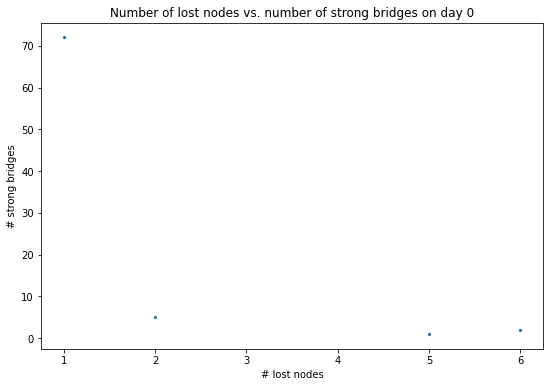

In [19]:
plt.figure(figsize=(9,6))
num_lost_se_c = Counter([i[2] for i in se_score_list[0]])
num_lost_se = list(zip(*(num_lost_se_c.items())))
plt.scatter(num_lost_se[0], num_lost_se[1], s=5, marker='o')
plt.title("Number of lost nodes vs. number of strong bridges on day 0")
plt.xlabel("# lost nodes")
plt.ylabel("# strong bridges")
# plt.xscale('log')
# plt.yscale('log')
plt.show();

In [17]:
sorted(se_score_list[0], key= lambda x : -x[1], reverse=True)

[[(4207, 3373), -0.002834983400816868, 6, 6],
 [(1594, 2859), -0.002729079694587866, 6, 5],
 [(3373, 3817), -0.0023497318316970306, 5, 5],
 [(1415, 2033), -0.0009707180285478485, 2, 3],
 [(1196, 3392), -0.0009707180285478485, 2, 3],
 [(831, 373), -0.0009707180285478485, 2, 3],
 [(373, 1190), -0.0009707180285478485, 2, 3],
 [(4354, 4329), -0.0008938337956012521, 2, 2],
 [(1965, 1083), -0.0004853709412099473, 1, 2],
 [(2876, 2218), -0.0004853709412099473, 1, 2],
 [(3805, 3029), -0.0004853709412099473, 1, 2],
 [(1969, 1394), -0.0004853709412099473, 1, 2],
 [(3404, 2038), -0.0004853709412099473, 1, 2],
 [(3501, 512), -0.0004853709412099473, 1, 2],
 [(1133, 2381), -0.0004853709412099473, 1, 2],
 [(2033, 2848), -0.0004853709412099473, 1, 2],
 [(3039, 3787), -0.0004853709412099473, 1, 2],
 [(3963, 3406), -0.0004853709412099473, 1, 2],
 [(3834, 4369), -0.0004853709412099473, 1, 2],
 [(3392, 2058), -0.0004853709412099473, 1, 2],
 [(1556, 2257), -0.0004853709412099473, 1, 2],
 [(627, 1940), -0.0

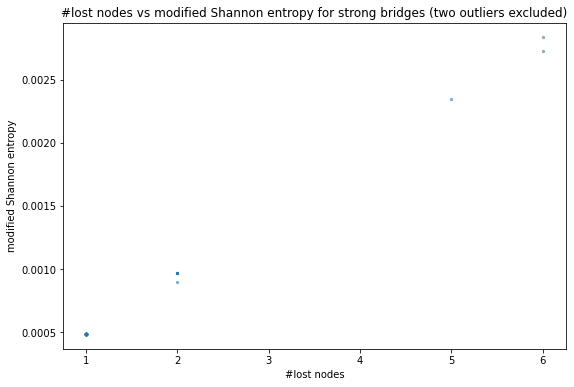

In [21]:
plt.figure(figsize=(9,6))
plt.scatter([i[2] for i in se_score_list[0]], [-i[1] for i in se_score_list[0]], s=5, marker='o', alpha=0.5)
# plt.xscale('log')
# plt.title("Indegree distribution")
# plt.xlim(0, 300)
plt.title("#lost nodes vs modified Shannon entropy for strong bridges")
plt.xlabel("#lost nodes")
plt.ylabel('modified Shannon entropy')
# plt.legend(frameon=False, fontsize=11, ncol=1, fancybox=False, shadow=True)
plt.show();

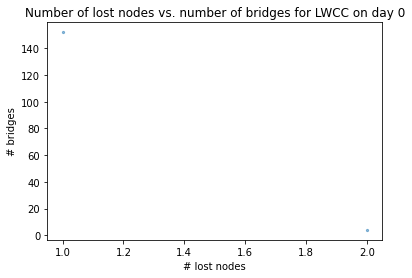

In [24]:
# plt.figure(figsize=(9,6))
num_lost_be_c = Counter([i[2] for i in bridge_score_list[0]])
num_lost_be = list(zip(*(num_lost_be_c.items())))
plt.scatter(num_lost_be[0], num_lost_be[1], s=5, marker='o', alpha=0.5)
plt.title("Number of lost nodes vs. number of bridges for LWCC on day 0")
plt.xlabel("# lost nodes")
plt.ylabel("# bridges")
# plt.xscale('log')
# plt.yscale('log')
plt.show();

In [23]:
sorted(bridge_score_list[0], key= lambda x : x[2], reverse=True)

[[(2731, 1020), -0.0004841977588693335, 2, 2],
 [(587, 2089), -0.0004841977588693335, 2, 2],
 [(112, 668), -0.0004841977588693335, 2, 2],
 [(4087, 3371), -0.0004841977588693335, 2, 2],
 [(2167, 2809), -0.0002614600982844649, 1, 2],
 [(1678, 4078), -0.0002614600982844649, 1, 2],
 [(2954, 2536), -0.0002614600982844649, 1, 2],
 [(1944, 4280), -0.0002614600982844649, 1, 2],
 [(3248, 3221), -0.0002614600982844649, 1, 2],
 [(4067, 1198), -0.0002614600982844649, 1, 2],
 [(3266, 3673), -0.0002614600982844649, 1, 2],
 [(790, 3673), -0.0002614600982844649, 1, 2],
 [(778, 3211), -0.0002614600982844649, 1, 2],
 [(2724, 3478), -0.0002614600982844649, 1, 2],
 [(2691, 2236), -0.0002614600982844649, 1, 2],
 [(3356, 4196), -0.0002614600982844649, 1, 2],
 [(621, 4196), -0.0002614600982844649, 1, 2],
 [(4261, 2395), -0.0002614600982844649, 1, 2],
 [(3880, 1339), -0.0002614600982844649, 1, 2],
 [(258, 4018), -0.0002614600982844649, 1, 2],
 [(3205, 3643), -0.0002614600982844649, 1, 2],
 [(2352, 3643), -0.0

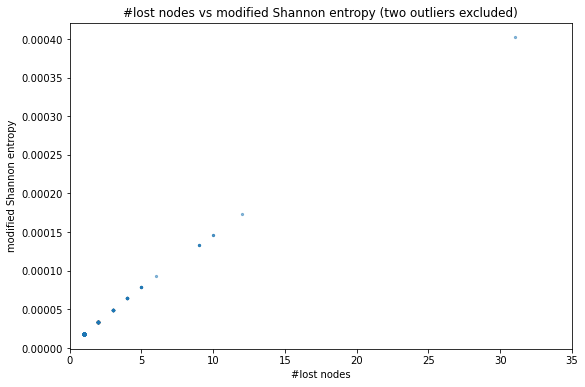

In [74]:
plt.figure(figsize=(9,6))
plt.scatter([i[2] for i in bridge_score_list[0]], [-i[1] for i in bridge_score_list[0]], s=5, marker='o', alpha=0.5)
# plt.xscale('log')
# plt.title("Indegree distribution")
plt.xlim(0, 35)
plt.title("#lost nodes vs modified Shannon entropy (two outliers excluded)")
plt.xlabel("#lost nodes")
plt.ylabel('modified Shannon entropy')
# plt.legend(frameon=False, fontsize=11, ncol=1, fancybox=False, shadow=True)
plt.show();

In [35]:
## lost nodes if bridge is deleted
def lost_nodes(e_list, subgraph_list, graph_lst, mode):
    avg_ind_list = []
    avg_view_list = []
#     for i, subgraph in enumerate(subgraph_list):
    candidates = [0] # , 15, 30, 45]:
    for i in candidates:
        sg = subgraph_list[i].copy()

        avg_ind = []
        avg_view = []
        print(i)
        for se in tqdm(e_list[i]):


            if mode=='weak':
                if sg.has_edge(*se):
                    src = se[0]
                    tgt = se[1]
                else:
                    src = se[1]
                    tgt = se[0]
                sg.remove_edge(src, tgt)                       
                components = sorted(nx.weakly_connected_components(sg), key=len)
                sg.add_edge(src, tgt)

            else:
                sg.remove_edge(*se)
                components = sorted(nx.strongly_connected_components(sg), key=len)
                sg.add_edge(*se)

            count = 0
            view_sum = 0
            indegree_sum = 0
            for c in components[:-1]:
                for v in c:
                    count += 1
                    view_sum += c_emb_avg_view_dict[v]
                    indegree_sum += graph_lst[i].in_degree(v)
            if count == 0:
                if not (sg.has_edge(*se) and sg.has_edge(se[1], se[0])):
                            print("graph: ", i, " has ", [len(component) for component in components], " components without ", se)
                            return None
            else:
                avg_ind.append(indegree_sum/count)
                avg_view.append(view_sum/count)        

        avg_ind_list.append(avg_ind)
        avg_view_list.append(avg_view)
    
    return avg_ind_list, avg_view_list

w_avg_ind_list, w_avg_view_list = lost_nodes(bridge_list, lwcc_subgraph_list, graph_lst, 'weak') 
s_avg_ind_list, s_avg_view_list = lost_nodes(se_list, lscc_subgraph_list, graph_lst, 'strong')

  4%|███▌                                                                              | 7/163 [00:00<00:02, 68.16it/s]

0


  4%|███                                                                                | 3/80 [00:00<00:02, 26.15it/s]

0


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:02<00:00, 26.76it/s]


Like video network, the artists cut off are of low popularity.

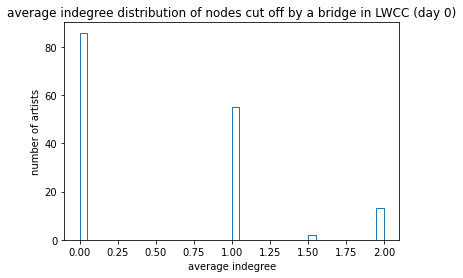

In [75]:
plt.hist(w_avg_ind_list[0], bins=40, density=False, log=False, histtype="step")
plt.title("average indegree distribution of nodes cut off by a bridge in LWCC (day 0)")
plt.ylabel('number of artists')
plt.xlabel('average indegree')
plt.show();
    

In [41]:
se = bridge_list[0][0]

In [42]:
sg = lwcc_subgraph_list[0].copy()
if sg.has_edge(*se):
    src = se[0]
    tgt = se[1]
else:
    src = se[1]
    tgt = se[0]
sg.remove_edge(src, tgt)                       
components = sorted(nx.weakly_connected_components(sg), key=len)
sg.add_edge(src, tgt)

In [47]:
graph_lst[0].out_degree([2167])

OutDegreeView({2167: 1})

In [43]:
components

[{2167},
 {0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49,
  50,
  52,
  53,
  54,
  55,
  56,
  57,
  58,
  59,
  60,
  61,
  62,
  63,
  64,
  65,
  66,
  67,
  68,
  69,
  71,
  72,
  73,
  74,
  75,
  76,
  77,
  78,
  79,
  80,
  81,
  82,
  83,
  84,
  85,
  86,
  87,
  88,
  89,
  90,
  91,
  92,
  93,
  94,
  95,
  96,
  97,
  98,
  99,
  100,
  101,
  102,
  103,
  104,
  105,
  106,
  107,
  108,
  109,
  110,
  111,
  112,
  113,
  114,
  115,
  116,
  118,
  119,
  120,
  121,
  122,
  123,
  124,
  125,
  126,
  127,
  128,
  129,
  130,
  132,
  133,
  134,
  135,
  136,
  137,
  138,
  139,
  140,
  141,
  142,
  143,
  144,
  146,
  147,
  148,
  150,
  151,
  152,
  153,
  154,
  155,
  156,
  157,
  158,
  159,
  160,
  161,
  162,
  163,

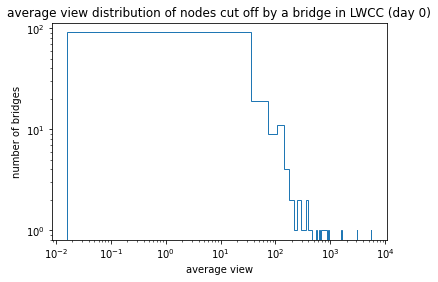

In [57]:
plt.hist(w_avg_view_list[0], bins=len(w_avg_ind_list[0]), density=False, log=True, histtype="step")
plt.title("average view distribution of nodes cut off by a bridge in LWCC (day 0)")
plt.ylabel('number of bridges')
plt.xlabel('average view')
plt.xscale('log')
plt.show();

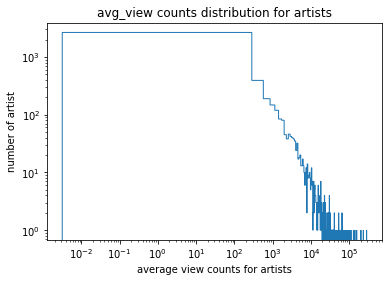

In [58]:
plt.hist(c_emb_avg_view_dict.values(), bins=1000, density=False, log=True, histtype="step")
plt.title("avg_view counts distribution for artists")
plt.xscale('log')
plt.ylabel('number of artist')
plt.xlabel('average view counts for artists')
plt.show();

In [65]:
a = [i for i in c_emb_avg_view_dict.items() if i[1] <1]
a

[(21, 0.12698412698412698),
 (137, 0.9761904761904762),
 (143, 0.9563492063492064),
 (162, 0.5238095238095238),
 (221, 0.38095238095238093),
 (324, 0.873015873015873),
 (405, 0.5079365079365079),
 (409, 0.21428571428571427),
 (441, 0.03968253968253968),
 (461, 0.5079365079365079),
 (487, 0.047619047619047616),
 (522, 0.08791208791208792),
 (529, 0.9365079365079365),
 (540, 0.38095238095238093),
 (555, 0.0582010582010582),
 (560, 0.6507936507936508),
 (564, 0.3217893217893218),
 (565, 0.9153439153439153),
 (586, 0.0873015873015873),
 (605, 0.7619047619047619),
 (658, 0.5317460317460317),
 (706, 0.3076923076923077),
 (709, 0.9047619047619048),
 (718, 0.4603174603174603),
 (781, 0.746031746031746),
 (823, 0.09523809523809523),
 (833, 0.06349206349206349),
 (859, 0.5),
 (883, 0.021164021164021163),
 (885, 0.753968253968254),
 (910, 0.38095238095238093),
 (920, 0.24603174603174602),
 (978, 0.746031746031746),
 (984, 0.047619047619047616),
 (1009, 0.47619047619047616),
 (1014, 0.126984126984

In [71]:
c_emb_v_emb_dict[137]

[24586, 40595]

In [72]:
embed_view_dict[24586]

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 0,
 0,
 0]

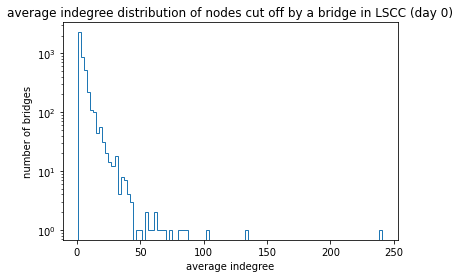

In [43]:
plt.hist(s_avg_ind_list[0], bins=100, density=False, log=True, histtype="step")
plt.title("average indegree distribution of nodes cut off by a bridge in LSCC (day 0)")
plt.ylabel('number of bridges')
plt.xlabel('average indegree')
plt.show();
    

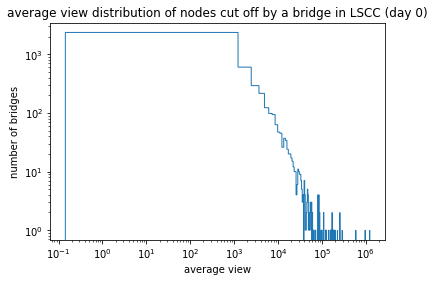

In [53]:
plt.hist(s_avg_view_list[0], bins=1000, density=False, log=True, histtype="step")
plt.title("average view distribution of nodes cut off by a bridge in LSCC (day 0)")
plt.ylabel('number of bridges')
plt.xlabel('average view')
plt.xscale('log')
plt.show();
    

There is no obvious relation between types of edge and bridges/strong edges.

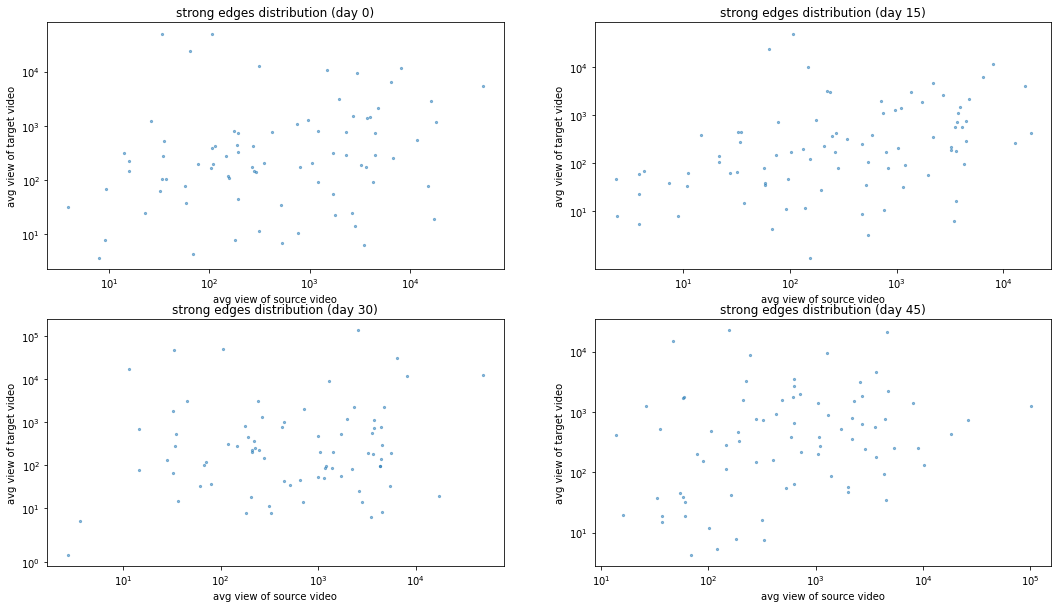

In [73]:
plt.figure(figsize=(18,10))
candidates = [0, 15, 30, 45]
for i, c in enumerate(candidates):
    plt.subplot(2,2,i+1)
    src_view = [c_emb_avg_view_dict[e[0]] for e in se_list[c]]
    tgt_view = [c_emb_avg_view_dict[e[1]] for e in se_list[c]]
    plt.scatter(src_view, tgt_view, s=5, marker='o', alpha=0.5)
    plt.xscale('symlog')
    plt.yscale('symlog')
    plt.title("strong edges distribution (day {0})".format((c)))
    plt.xlabel("avg view of source video")
    plt.ylabel("avg view of target video")

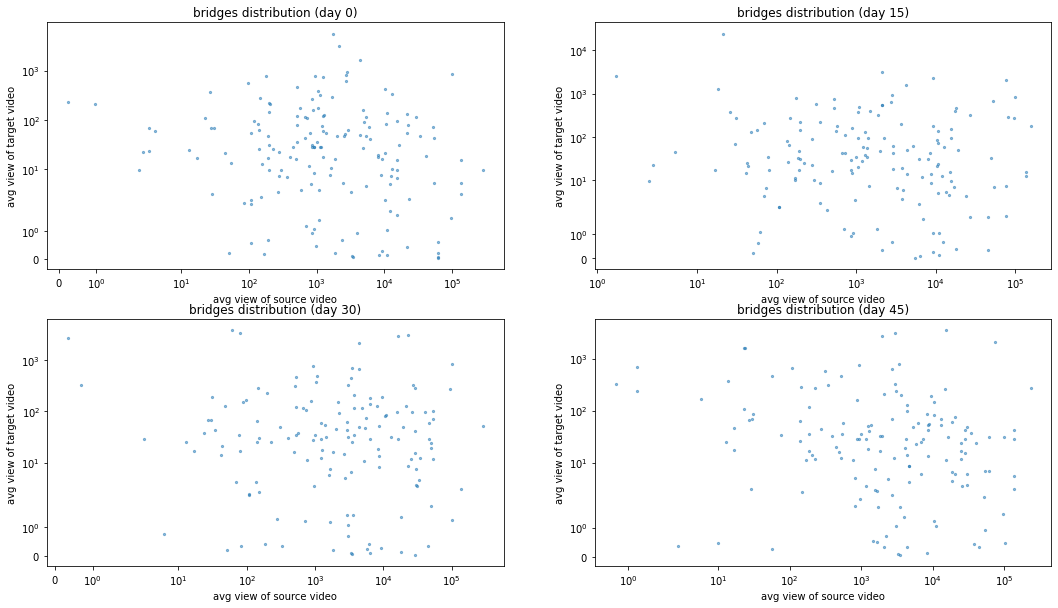

In [74]:
plt.figure(figsize=(18,10))
candidates = [0, 15, 30, 45]
for i, c in enumerate(candidates):
    plt.subplot(2,2,i+1)
    src_view = [c_emb_avg_view_dict[e[0]] for e in bridge_list[c]]
    tgt_view = [c_emb_avg_view_dict[e[1]] for e in bridge_list[c]]
    plt.scatter(src_view, tgt_view, s=5, marker='o', alpha=0.5)
    plt.xscale('symlog')
    plt.yscale('symlog')
    plt.title("bridges distribution (day {0})".format((c)))
    plt.xlabel("avg view of source video")
    plt.ylabel("avg view of target video")

In [58]:
len(src_view_small)

53

In [59]:
avg_view_small = [i for i in embed_avg_view_dict.values() if i < 1]

In [60]:
len(avg_view_small)

4186

In [26]:
dict_path = os.path.join(data_prefix, "channel_id_embed_dict.pkl")
with open(dict_path, 'rb') as fin:
        cid_embed_dict = pickle.load(fin) # c_embed

In [27]:
embed_cid_dict = data_loader.embed_cid_dict 

In [32]:
c_emb_v_emb_dict = defaultdict(list)
c_emb_view_dict = defaultdict(list)
c_emb_avg_view_dict = {}
c_emb_daily_avg_view_dict = {}
for v_emb in range(num_videos):
    cid = embed_cid_dict[v_emb]
    c_emb = cid_embed_dict[cid]
    c_emb_v_emb_dict[c_emb].append(v_emb)
    c_emb_view_dict[c_emb].append(embed_view_dict[v_emb])

for c_emb in cid_embed_dict.values():
    c_emb_avg_view_dict[c_emb] = np.mean(c_emb_view_dict[c_emb])
    c_emb_daily_avg_view_dict[c_emb] = list(np.mean(c_emb_view_dict[c_emb], axis=0))

In [34]:
c_emb_avg_view_dict[0]

4109.619047619048